<a href="https://colab.research.google.com/github/transponster27/CS6271-UL2024/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GE

In [ ]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install deap
!pip install functions
!pip install elitism

import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
from deap import creator, base, tools

import random
import matplotlib.pyplot as plt

from elitism import eaSimpleWithElitism

ERROR: Could not find a version that satisfies the requirement elitism (from versions: none)
ERROR: No matching distribution found for elitism


In [ ]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be smaller or equal to HALLOFFAME_SIZE
HALLOFFAME_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be at least 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [ ]:
X_train = np.zeros([4,16], dtype=bool)
Y_train = np.zeros([16,], dtype=bool)

data = pd.read_table(r"/content/parity4.csv")
for i in range(4):
    for j in range(16):
        X_train[i,j] = data['d'+ str(i)].iloc[j]
for i in range(16):
    Y_train[i] = data['output'].iloc[i]

GRAMMAR_FILE = '/content/parity4.bnf'

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


In [ ]:
with open(GRAMMAR_FILE, 'r') as f:
    GRAMMAR = f.read()
print(GRAMMAR)

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]


In [ ]:
BNF_GRAMMAR = grape.Grammar(GRAMMAR_FILE)

In [ ]:

def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

In [ ]:
getoolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

getoolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

getoolbox.register("evaluate", fitness_eval)

# Tournament selection:
getoolbox.register("select", tools.selTournament, tournsize=6)

# Single-point crossover:
getoolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
getoolbox.register("mutate", grape.mutation_int_flip_per_codon)

In [ ]:
# create initial population (generation 0):
gepopulation = getoolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
gepopulation, logbook = algorithms.ge_eaSimpleWithElitism(gepopulation, getoolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (6.0,) , Number of invalids = 105
gen = 2 , Best fitness = (6.0,) , Number of invalids = 60
gen = 3 , Best fitness = (6.0,) , Number of invalids = 30
gen = 4 , Best fitness = (4.0,) , Number of invalids = 18
gen = 5 , Best fitness = (4.0,) , Number of invalids = 15
gen = 6 , Best fitness = (4.0,) , Number of invalids = 16
gen = 7 , Best fitness = (3.0,) , Number of invalids = 25
gen = 8 , Best fitness = (3.0,) , Number of invalids = 14
gen = 9 , Best fitness = (3.0,) , Number of invalids = 11
gen = 10 , Best fitness = (3.0,) , Number of invalids = 6
gen = 11 , Best fitness = (3.0,) , Number of invalids = 9
gen = 12 , Best fitness = (3.0,) , Number of invalids = 6
gen = 13 , Best fitness = (2.0,) , Number of invalids = 4
gen = 14 , Best fitness = (2.0,) , Number of invalids = 3
gen = 15 , Best fitness = (2.0,) , Number of invalids = 5
gen = 16 , Best fitness = (2.0,) , Number of invalids = 5
gen = 17 , Best fitness = (2.0,) , Numb

In [ ]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.000000,0.497996,6.0,10.0,189,102.240000,32,17.540000,9.028000,68.160000,126,0.000000,0.230207
1,1,105,7.886076,0.564506,6.0,10.0,189,140.536709,32,15.860759,11.106329,61.443038,126,0.006640,0.929575
2,2,60,7.775000,0.630161,6.0,10.0,189,174.779545,32,19.029545,13.790909,74.118182,126,0.006216,1.164119
3,3,30,7.674468,0.698317,6.0,10.0,189,200.597872,32,21.227660,15.612766,82.910638,126,0.006626,1.381247
4,4,18,7.502075,0.794820,4.0,10.0,189,217.827801,32,22.659751,16.327801,88.639004,126,0.013094,1.554188
5,5,15,7.336082,0.933035,4.0,12.0,189,232.383505,32,25.647423,17.395876,100.589691,126,0.026609,1.897475
6,6,16,7.330579,1.112576,4.0,10.0,189,249.456612,32,25.747934,17.628099,100.991736,126,0.005175,1.882201
7,7,25,7.149474,1.189770,3.0,11.0,533,274.046316,43,26.383158,18.048421,103.532632,170,0.014479,2.970291
8,8,14,7.092593,1.294840,3.0,12.0,533,304.209877,43,28.565844,18.724280,112.263374,170,0.013357,1.316897
9,9,11,6.916155,1.419671,3.0,10.0,533,329.415133,43,30.212679,19.310838,118.850716,170,0.003535,0.824363


In [ ]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 nand_(nor_(nor_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[0],x[3]))),and_(nor_(nor_(x[1],x[1]),nor_(x[0],x[0])),nor_(and_(x[1],x[2]),or_
(x[3],x[3])))),and_(nand_(and_(nand_(x[0],x[2]),nand_(x[1],x[3])),nor_(nor_(x[3]
,x[0]),nand_(x[2],x[2]))),nand_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(
x[0],x[3]),and_(x[0],x[3])))))

Training Fitness:  0.0
Depth:  13
Length of the genome:  1110
Used portion of the genome: 0.11


<ErrorbarContainer object of 3 artists>

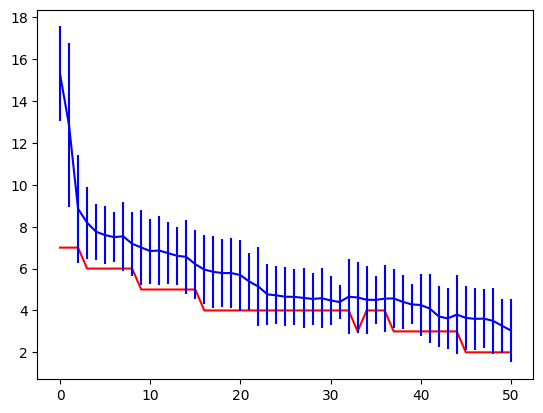

In [ ]:
plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

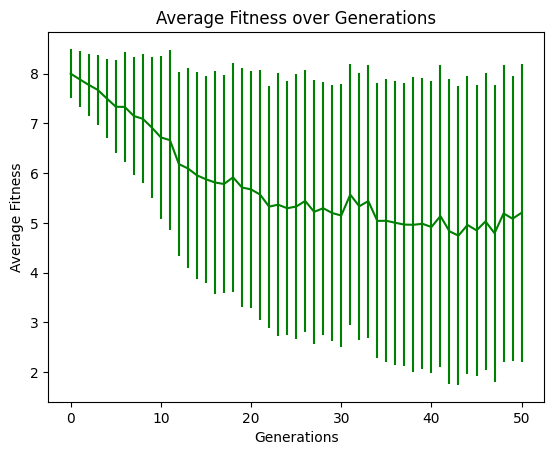

In [ ]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

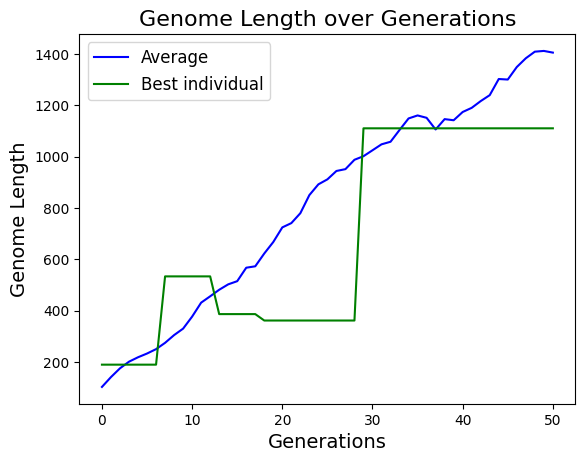

In [ ]:

plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

#setup 2
c= 0.7

m= 0.02

gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (6.0,) , Number of invalids = 98
gen = 2 , Best fitness = (5.0,) , Number of invalids = 69
gen = 3 , Best fitness = (5.0,) , Number of invalids = 40
gen = 4 , Best fitness = (5.0,) , Number of invalids = 32
gen = 5 , Best fitness = (5.0,) , Number of invalids = 22
gen = 6 , Best fitness = (5.0,) , Number of invalids = 24
gen = 7 , Best fitness = (5.0,) , Number of invalids = 26
gen = 8 , Best fitness = (5.0,) , Number of invalids = 32
gen = 9 , Best fitness = (4.0,) , Number of invalids = 29
gen = 10 , Best fitness = (4.0,) , Number of invalids = 23
gen = 11 , Best fitness = (4.0,) , Number of invalids = 24
gen = 12 , Best fitness = (4.0,) , Number of invalids = 24
gen = 13 , Best fitness = (4.0,) , Number of invalids = 19
gen = 14 , Best fitness = (4.0,) , Number of invalids = 19
gen = 15 , Best fitness = (4.0,) , Number of invalids = 9
gen = 16 , Best fitness = (4.0,) , Number of invalids = 8
gen = 17 , Best fitness = (4.0,) , 

<ErrorbarContainer object of 3 artists>

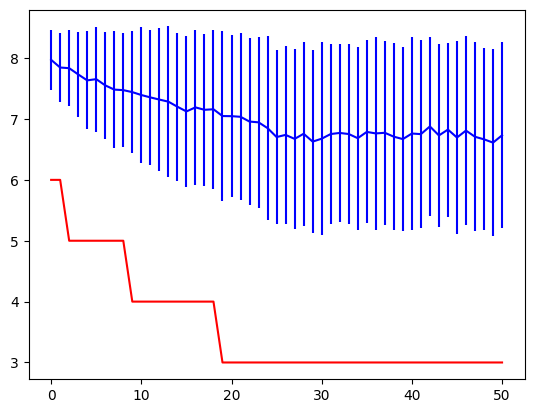

In [ ]:
from elitism import eaSimpleWithElitism

# create initial population (generation 0):
gepopulation2 = getoolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
gepopulation2, logbook2 = algorithms.ge_eaSimpleWithElitism(gepopulation2, getoolbox, cxpb=0.7, mutpb=0.02,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

maxFitness, meanFitness, stdFitness, minFitness = logbook2.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#setup 3
c= 0.8

m= 0.07

gen = 0 , Best fitness = (5.0,)
gen = 1 , Best fitness = (5.0,) , Number of invalids = 83
gen = 2 , Best fitness = (5.0,) , Number of invalids = 76
gen = 3 , Best fitness = (5.0,) , Number of invalids = 54
gen = 4 , Best fitness = (5.0,) , Number of invalids = 25
gen = 5 , Best fitness = (5.0,) , Number of invalids = 25
gen = 6 , Best fitness = (5.0,) , Number of invalids = 17
gen = 7 , Best fitness = (5.0,) , Number of invalids = 13
gen = 8 , Best fitness = (5.0,) , Number of invalids = 12
gen = 9 , Best fitness = (5.0,) , Number of invalids = 5
gen = 10 , Best fitness = (5.0,) , Number of invalids = 4
gen = 11 , Best fitness = (5.0,) , Number of invalids = 5
gen = 12 , Best fitness = (5.0,) , Number of invalids = 7
gen = 13 , Best fitness = (5.0,) , Number of invalids = 5
gen = 14 , Best fitness = (5.0,) , Number of invalids = 7
gen = 15 , Best fitness = (5.0,) , Number of invalids = 7
gen = 16 , Best fitness = (5.0,) , Number of invalids = 5
gen = 17 , Best fitness = (5.0,) , Number

<ErrorbarContainer object of 3 artists>

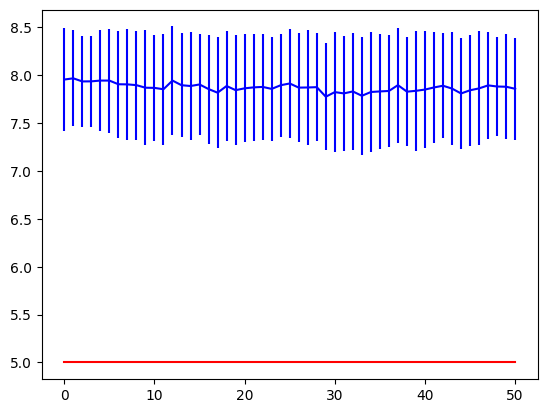

In [ ]:
# create initial population (generation 0):
gepopulation3 = getoolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
gepopulation3, logbook3 = algorithms.ge_eaSimpleWithElitism(gepopulation3, getoolbox, cxpb=0.8, mutpb=0.07,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

maxFitness, meanFitness, stdFitness, minFitness = logbook3.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

## GP

In [ ]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx

In [ ]:
MIN_INIT_TREE_HEIGHT = MIN_INIT_TREE_DEPTH
MAX_INIT_TREE_HEIGHT = MAX_INIT_TREE_DEPTH
LIMIT_TREE_HEIGHT = MAX_TREE_DEPTH
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

In [ ]:
pset = gp.PrimitiveSet("MAIN", 4)

def opNand(a, b):
    return np.logical_not(np.logical_and(a, b))
def opNor(a, b):
    return np.logical_not(np.logical_or(a, b))

# not_, and_, or_, nand_, nor_
pset.addPrimitive(operator.not_, 1)
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(opNand, 2)
pset.addPrimitive(opNor, 2)

pset.addTerminal(np.bool_(1))
pset.addTerminal(np.bool_(0))

In [ ]:
def gpFitness(ind, toolbox, points):
    x,Y = points

    func = toolbox.compile(expr=ind)

    try:
        pred = func(*x)
    except Exception:
        return len(Y),

    assert np.isrealobj(pred)

    nSample = len(Y)
    compare = np.equal(Y, pred)
    nCorrect = np.sum(compare)

    fitness = nSample - nCorrect

    return fitness,

In [ ]:
gptoolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

gptoolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INIT_TREE_HEIGHT, max_=MAX_INIT_TREE_HEIGHT)
gptoolbox.register("individualCreator", tools.initIterate, creator.Individual, gptoolbox.expr)
gptoolbox.register("populationCreator", tools.initRepeat, list, gptoolbox.individualCreator)
gptoolbox.register("compile", gp.compile, pset=pset)
gptoolbox.register("evaluate", gpFitness, toolbox=gptoolbox, points=[X_train, Y_train])

gptoolbox.register("select", tools.selTournament, tournsize=6)
gptoolbox.register("mate", gp.cxOnePoint)
gptoolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
gptoolbox.register("mutate", gp.mutUniform, expr=gptoolbox.expr_mut, pset=pset)

gptoolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
gptoolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

In [ ]:
gppopulation = gptoolbox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

gppopulation, logbook = algorithms.eaSimple(gppopulation,
                                                  gptoolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=stats,
                                                  halloffame=hof,
                                                  verbose=False)

In [ ]:
maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

bestIndLen = logbook.select("best_ind_length")
avgIndLen = logbook.select("avg_length")

selectionTime = logbook.select("selection_time")
generationTime = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avgUsedCodons = logbook.select("avg_used_codons")
bestIndUsedCodons = logbook.select("best_ind_used_codons")

bestIndNodes = logbook.select("best_ind_nodes")
avgNodes = logbook.select("avg_nodes")

avgDepth = logbook.select("avg_depth")

results = pd.DataFrame(
    list(
        zip(
            gen,
            invalid,
            meanFitness,
            stdFitness,
            minFitness,
            maxFitness,
            bestIndLen,
            avgIndLen,
            bestIndNodes,
            avgNodes,
            avgDepth,
            avgUsedCodons,
            bestIndUsedCodons,
            selectionTime,
            generationTime,
        )
    ),
    columns=REPORT_ITEMS,
)

results

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,None,15.388,2.134820,7.0,16.0,None,None,None,None,None,None,None,None,None
1,1,None,13.660,3.645326,7.0,16.0,None,None,None,None,None,None,None,None,None
2,2,None,9.666,3.274514,7.0,16.0,None,None,None,None,None,None,None,None,None
3,3,None,8.276,1.770826,7.0,16.0,None,None,None,None,None,None,None,None,None
4,4,None,8.080,1.840000,7.0,16.0,None,None,None,None,None,None,None,None,None
5,5,None,7.680,1.553577,6.0,16.0,None,None,None,None,None,None,None,None,None
6,6,None,7.612,1.628943,6.0,16.0,None,None,None,None,None,None,None,None,None
7,7,None,7.632,1.979034,6.0,16.0,None,None,None,None,None,None,None,None,None
8,8,None,7.022,1.342206,6.0,16.0,None,None,None,None,None,None,None,None,None
9,9,None,6.784,1.526219,5.0,16.0,None,None,None,None,None,None,None,None,None


<ErrorbarContainer object of 3 artists>

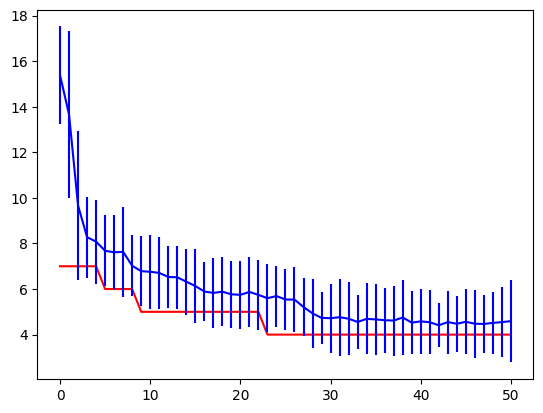

In [ ]:
plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#setup 2
c= 0.7

m= 0.02

<ErrorbarContainer object of 3 artists>

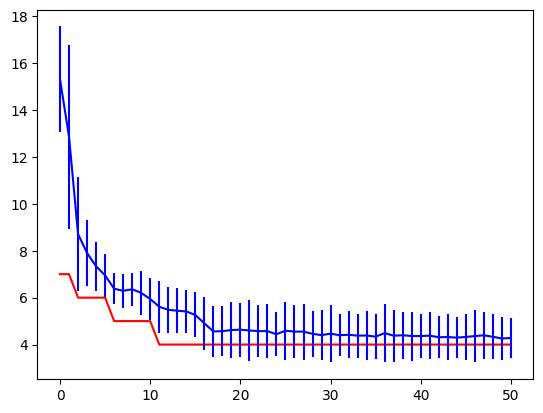

In [ ]:
gppopulation2 = gptoolbox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

gppopulation2, logbook2 = algorithms.eaSimple(
    gppopulation2,
    gptoolbox,
    cxpb=0.7,
    mutpb=0.02,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=hof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook2.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#setup 3
c= 0.8

m= 0.07

<ErrorbarContainer object of 3 artists>

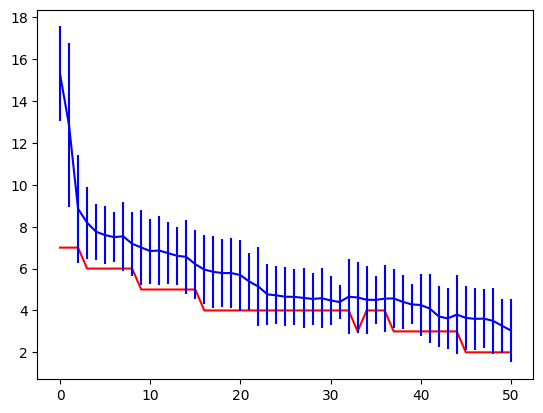

In [ ]:
gppopulation3 = gptoolbox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

gppopulation3, logbook3 = algorithms.eaSimple(
    gppopulation3,
    gptoolbox,
    cxpb=0.8,
    mutpb=0.07,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=hof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook3.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#Comparison:

Setups for Experiments:

Setup 1:

mutation probability (m) = 0.01

crossover probability (c) = 0.8

Setup 2: m = 0.02, c = 0.7

Setup 3: m = 0.07, c = 0.8


While GP and GE both succeeded in solving the 4-bit parity problem. Their performance in each configuration is:



Setup 1: In comparison to GP, GE exhibited a quicker rate of convergence and discovered the ideal solution (fitness = 0) in fewer generations.

Setup 2: Although GE converged more quickly, GP's performance marginally improved with reduced crossover and greater mutation rates.

Setup 3: As with Setup 2, GE continued to be more effective in identifying the best solution, while GP's performance marginally improved.


On the 4-bit parity issue, GE outperformed GP in terms of efficiency and consistency. Its quicker convergence was probably aided by GE's elitism policy. The sensitivity of both methods to crossover and mutation probability demonstrated how crucial parameter adjustment is for achieving the best results.

This is because, by preserving the greatest people from each generation, GE's use of elitism speeds up convergence and a more organized search space offered by GE's grammar-based encoding helps to better direct the evolutionary process. Also, in contrast to GP's fixed-length trees, GE's variable-length genomes give users greater freedom while navigating the search area.

In conclusion, GE appears to be a more effective option for developing solutions than GP. Nevertheless, the performance may differ based on the particulars of the problem and the parameters used and can be continuously compared by adjusting the parameters to get the best outcomes.